<a href="https://colab.research.google.com/github/vishal19217/CyberBullying_Sentiment_Analysis/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install matplotlib --upgrade
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install emoji
!pip install unidecode
#Text cleaning
import re, string
import emoji
import unidecode 
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))


#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<Figure size 432x288 with 0 Axes>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:



df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cyberbullying_tweets.csv")

In [59]:
df.head()
df.info()
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})
df.duplicated().sum()
df = df[~df.duplicated()]
df.info()
df.sentiment.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47656 non-null  object
 1   sentiment  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: sentiment, dtype: int64

In [60]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = unidecode.unidecode(text) #remove texts such as  àéêöhello
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

# Stemming just removes or stems the last few characters of a word, often leading to incorrect meanings and spelling. 
# Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma. 
# Sometimes, the same word can have multiple different Lemmas.
#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
#NOTE:Stemming seems to work better for this dataset
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def deep_clean(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [61]:
texts_new = []
for t in df.text:
    texts_new.append(deep_clean(t))
df['text_clean'] = texts_new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  """


In [63]:
df.head()
display(df["text_clean"].duplicated().sum())
df.drop_duplicates("text_clean", inplace=True)
df.sentiment.value_counts()


0

religion               7946
age                    7884
ethnicity              7744
not_cyberbullying      7640
gender                 7623
other_cyberbullying    5796
Name: sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


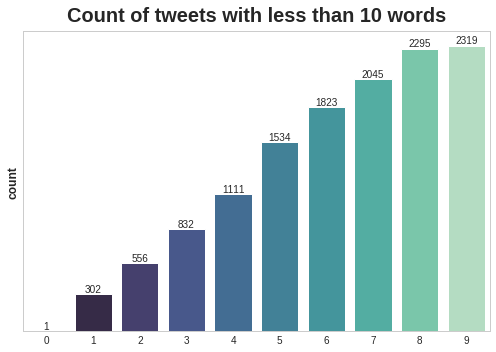

In [64]:
df = df[df["sentiment"]!="other_cyberbullying"]
sentiments = ["religion","age","ethnicity","gender","not bullying"]
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
df['text_len'] = text_len
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
ax.bar_label(ax.containers[0])
plt.yticks([])
plt.ylabel('count')
plt.xlabel('')
plt.show()

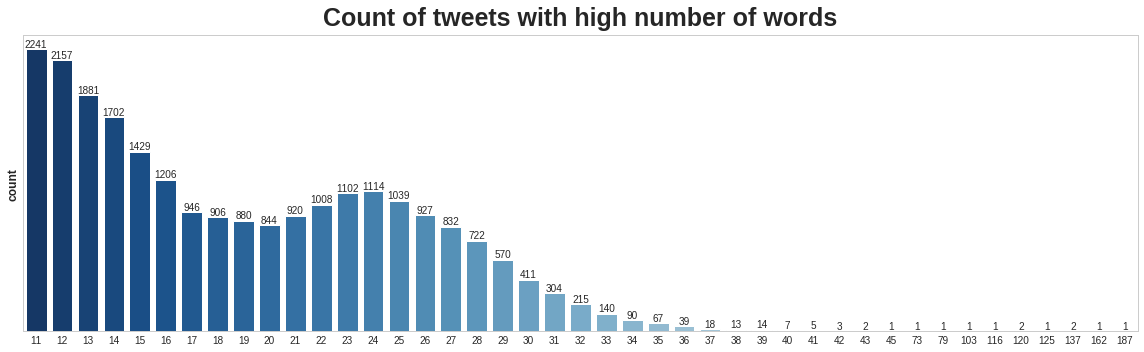

,text,sentiment,text_clean,text_len
4846,@andrea_gcav: @viviaanajim recuerdas como noso...,not_cyberbullying,recuerda como nosotra tambien eramo victima de...,79
44294,@JasmineLovvee If He Dont Want You Well Fuck H...,ethnicity,dont want well fuck aint worth tear never swea...,73
45930,"Get off ur ego trip, take off ur rose colored ...",ethnicity,get ur ego trip take ur rose color glass amp g...,45
21241,And yet God was able to meet their needs using...,religion,yet god abl meet need use radic everyday gener...,43
41749,@seijohgorl hoy mami keito AAAA okay so um ika...,ethnicity,hoy mami keito aaaa okay um ikaw talaga one fi...,43
...,...,...,...,...
22446,@buttercupashby @MaDaSaHaTtEr_17 And you lie a...,religion,lie major muslim forc,4
3554,@Aiiane awesome! Can't wait to hear from you.,not_cyberbullying,awesom ca wait hear,4
895,Let's go Katy's Birthday!!!,not_cyberbullying,let go kati birthday,4
17161,@SumerSloan @PAWarnhoff @etsho127 I know this ...,religion,know peopl fight assad,4


In [65]:
#removing the text lines with <3 words and >100 words
df = df[df['text_len'] > 3]
df.sort_values(by=['text_len'], ascending=False)
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()
df = df[df['text_len'] < 100]
df.sort_values(by=["text_len"], ascending=False)

In [66]:
#Encoding the numerically encoding the labels
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4}) 
df.head()

,text,sentiment,text_clean,text_len
0,"In other words #katandandre, your food was cra...",4,word katandandr food crapilici mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,4,aussietv white mkr theblock today sunris studi...,10
2,@XochitlSuckkks a classy whore? Or more red ve...,4,classi whore red velvet cupcak,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",4,meh p thank head concern anoth angri dude twitter,9
4,@RudhoeEnglish This is an ISIS account pretend...,4,isi account pretend kurdish account like islam...,8


In [67]:
#Word2Vec Embedding
from nltk.tokenize import TweetTokenizer
from gensim.models import Word2Vec
tokenizer = TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)
class MeanEmbeddingVectorizer():
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) for words in X])
    
    def fit(self, X, y):
        return self

df["tokenized"] = [tokenizer.tokenize(i) for i in df['text_clean']]
model = Word2Vec(df["tokenized"], min_count=1)


In [68]:
keys_dict = model.wv.vocab
# print(keys_dict.keys())
w2v = dict(zip(keys_dict.keys(), model.wv.vectors)) 
modelw = MeanEmbeddingVectorizer(w2v)
# df["cyberbullying_type_code"] = df.sentiment.astype('category').cat.codes
# display(df.head())
# df["cyberbullying_type_code"].unique()


In [69]:
#Train and Splitting the dataset
#Seed for reproducibility
import random
import torch

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
X = df['tokenized']
y = df['sentiment']
#Training and Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X.head()

0             [word, katandandr, food, crapilici, mkr]
1    [aussietv, white, mkr, theblock, today, sunris...
2                 [classi, whore, red, velvet, cupcak]
3    [meh, p, thank, head, concern, anoth, angri, d...
4    [isi, account, pretend, kurdish, account, like...
Name: tokenized, dtype: object

In [70]:
#Splitting the validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)


In [71]:
(unique, counts) = np.unique(y_train, return_counts=True)
# np.asarray((unique,counts))
np.asarray((unique, counts)).T

array([[   0, 5682],
       [   1, 5638],
       [   2, 5549],
       [   3, 5275],
       [   4, 4594]])

In [28]:
# ros = RandomOverSampler()
# # display(np.array(X_train.reshape(-1,1)))
# X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
# train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);
# X_train = train_os['text_clean'].values
# y_train = train_os['sentiment'].values
# (unique, counts) = np.unique(y_train, return_counts=True)
# np.asarray((unique, counts)).T

array([[   0, 5682],
       [   1, 5682],
       [   2, 5682],
       [   3, 5682],
       [   4, 5682]])

In [ ]:
# #Naive Bayes
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB


# clf = CountVectorizer()
# X_train_cv =  clf.fit_transform(X_train)
# X_test_cv = clf.transform(X_test)
# X_train_cv
# #associating weights to the different words based on their frequency
# tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
# X_train_tf = tf_transformer.transform(X_train_cv)
# X_test_tf = tf_transformer.transform(X_test_cv)

In [72]:
#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler


# clf = CountVectorizer()
# scaler = MinMaxScaler()

X_train_vectors_w2v = modelw.transform(X_train)
X_test_vectors_w2v = modelw.transform(X_test)
display(X_train_vectors_w2v.max(),X_train_vectors_w2v.min())
# X_train_vectors_w2v = scaler.fit_transform(X_train_vectors_w2v)
# X_test_vectors_w2v = scaler.fit_transform(X_test_vectors_w2v)
# display(X_train_vectors_w2v)

1.5521218

-2.2268748

In [73]:
from sklearn.metrics import classification_report, confusion_matrix
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.35      0.72      0.48      1579
         age       0.79      0.76      0.78      1566
   ethnicity       0.53      0.37      0.43      1542
      gender       0.33      0.11      0.17      1465
not bullying       0.42      0.37      0.39      1276

    accuracy                           0.48      7428
   macro avg       0.49      0.47      0.45      7428
weighted avg       0.49      0.48      0.46      7428



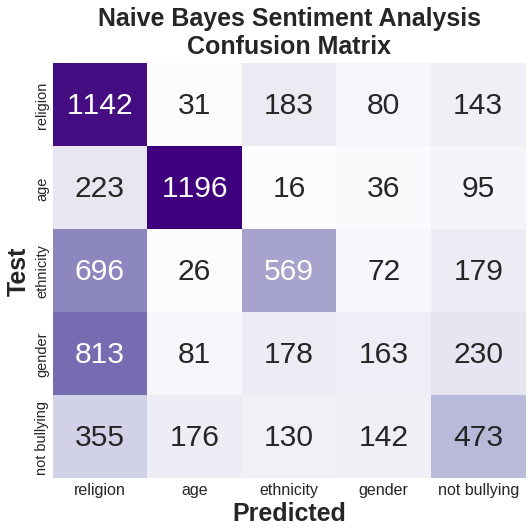

In [74]:
nb_clf = GaussianNB()
nb_clf.fit(X_train_vectors_w2v, y_train)
nb_pred = nb_clf.predict(X_test_vectors_w2v)
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', sentiments)



In [ ]:
import os
import urllib.request
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.manifold import TSNE
import numpy as np
# urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')
# # !unzip "/content/glove.6B.zip" -d "/content/"
# !unzip "/content/glove.6B.zip" -d "/content/"
emmbed_dict = {}
with open('/content/glove.6B.200d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector


#Naive Bayes
print(emmbed_dict)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def transform_sent(x_train):
  trainv=[]
  # print(X_train[0])
  # print(X_train[1])
  for s in X_train:
    values = s.split(' ')
    print(values)
    break
    sentv = []
    for word in values:
      if(word in emmbed_dict.keys()):
        vector = emmbed_dict[word]
        vector = list(vector)
      else:
        vector = [0]*200
      sentv = sentv+vector
    trainv.append(np.array(sentv))


trainv = np.array(transform_sent(X_train))
# testv = np.array(transform_sent(X_test))   
print(trainv.shape)
nb_clf = MultinomialNB()
nb_clf.fit(trainv, y_train)
nb_pred = nb_clf.predict(testv)
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))
# conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', sentiments)   
    


In [ ]:
#Creating frequency distribution of words using nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
text="""Achievers are not afraid of Challenges, rather they relish them, thrive in them, use them. Challenges makes is stronger.
        Challenges makes us uncomfortable. If you get comfortable with uncomfort then you will grow. Challenge the challenge """
#Tokenize the sentences from the text corpus
tokenized_text=sent_tokenize(text)
#using CountVectorizer and removing stopwords in english language
cv1= CountVectorizer(lowercase=True,stop_words='english')
#fitting the tokenized sentences to the countvectorizer
text_counts=cv1.fit_transform(tokenized_text)
display(tokenized_text)
# display(cv1.vocabulary_)

print(text_counts.toarray())
print(text_counts)
tf_transformer = TfidfTransformer(use_idf=True).fit(text_counts)
X_train_tf = tf_transformer.transform(text_counts)
print(X_train_tf.toarray())


['Achievers are not afraid of Challenges, rather they relish them, thrive in them, use them.',
 'Challenges makes is stronger.',
 'Challenges makes us uncomfortable.',
 'If you get comfortable with uncomfort then you will grow.',
 'Challenge the challenge']

[[1 1 0 1 0 0 0 1 0 1 0 0 1]
 [0 0 0 1 0 0 1 0 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 1 1 0 0 0 0 1 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0]]
  (0, 0)	1
  (0, 1)	1
  (0, 3)	1
  (0, 7)	1
  (0, 9)	1
  (0, 12)	1
  (1, 3)	1
  (1, 6)	1
  (1, 8)	1
  (2, 3)	1
  (2, 6)	1
  (2, 11)	1
  (3, 4)	1
  (3, 10)	1
  (3, 5)	1
  (4, 2)	2
[[0.42841136 0.42841136 0.         0.28691208 0.         0.
  0.         0.42841136 0.         0.42841136 0.         0.
  0.42841136]
 [0.         0.         0.         0.4622077  0.         0.
  0.55681615 0.         0.69015927 0.         0.         0.
  0.        ]
 [0.         0.         0.         0.4622077  0.         0.
  0.55681615 0.         0.         0.         0.         0.69015927
  0.        ]
 [0.         0.         0.         0.         0.57735027 0.57735027
  0.         0.         0.         0.         0.57735027 0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0

In [ ]:
import os
import urllib.request
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.manifold import TSNE
import numpy as np
urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')
# !unzip "/content/glove.6B.zip" -d "/content/"



('glove.6B.zip', <http.client.HTTPMessage at 0x7fdf906f1310>)

In [ ]:
!unzip "/content/glove.6B.zip" -d "/content/"

emmbed_dict = {}
with open('/content/glove.6B.200d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

Archive:  /content/glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


In [ ]:
X_train.head()

NameError: ignored